## Contrastive learning on the unit circle

We illustrate the contrastive learning task of SimCLR on a simplistic example.
Inputs are points on the unit circle, and we take a look that minimizer of the SimCLR contrastive learning objective (instance discrimination via the InfoNCE loss).
The contrastive learning objective requires the model to "distinguish each point from others".
This is satisfied by a model that spreads out input points as uniformly as possible over the unit circle.

### Imports

In [14]:
from math import pi
from typing import List, Optional, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader

import src.simclr as simclr
from src.data_loading import get_data_loader
from src.utils import accuracy

### Helper functions

In [15]:
def to_xy(theta: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return the cartesian coordinates (x, y) of points on the unit circle identified by its angle theta"""
    return np.cos(theta), np.sin(theta)


def to_dataset(thetas: np.ndarray) -> data.TensorDataset:
    """Convert a 1-D numpy array of angles to a tensor dataset."""
    d = torch.from_numpy(thetas.reshape(-1, 1)).float()
    return data.TensorDataset(d)


def plot_thetas_tensor(
    thetas: torch.Tensor,
    color: str,
    label: str,
    indices: Optional[List[int]] = None,
):
    """Plot B points on the unit circle, identified by their angle and stored in a tensor of shape [B, 1].
    
    Accepts an optional list of indices of length B to identify the index of each angle in a matplotlib colormap.
    """
    plt.figure()
    thetas_arr = thetas.detach().numpy()
    n = thetas_arr.shape[0]
    if indices is not None:
        assert sorted(indices) == list(range(n))
    else:
        indices = list(range(n))
    x, y = to_xy(thetas_arr)
    norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
    for c_ix, ix in enumerate(indices):
        plt.scatter(x[ix], y[ix], c=c_ix, cmap="viridis", norm=norm)
    plt.title(label)
    plt.grid()
    plt.show()
    plt.close()

### Basic SimCLR training loop

In [16]:
def train_simclr(
    data: DataLoader,
    model: nn.Module,
    lr: float,
    decay: float,
    n_epochs: int = 100,
    plot_every: int = 10,
    print_every: int = 10,
):
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr, weight_decay=decay, momentum=0.9
    )
    transform = (
        lambda tensor: tensor
    )  # We use the "dummy" identity transform for this simple SimCLR example
    for e_ix in range(n_epochs):
        for (step_ix, thetas) in enumerate(data):
            thetas = thetas[0]  # thetas is a length-1 list
            loss, (logits, labels), debug = simclr.step(
                thetas, model, transform, normalize=True
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if plot_every and ((e_ix == 1) or (e_ix + 1) % plot_every == 0):
            indices = np.argsort(thetas.detach().numpy().flatten())
            plot_thetas_tensor(thetas, "blue", "Input points", indices)
            plot_thetas_tensor(
                debug[2], "green", "SimCLR encoder outputs", indices
            )
        if print_every and (e_ix + 1) % print_every == 0:
            print(f"loss: {loss.item():.3f}")
            print(f"contrastive accuracy: {accuracy(logits, labels):.3f}")

### Generate input data on a restricted portion of the unit circle

100

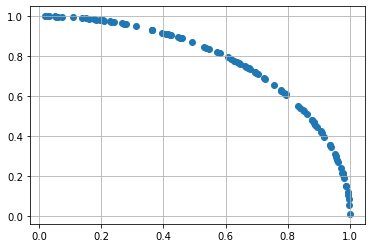

In [17]:
n_points = 100
min_theta, max_theta = (0.0, pi / 2)
thetas = np.random.rand(n_points) * (max_theta - min_theta) + min_theta


x, y = to_xy(thetas)
plt.scatter(x, y)
plt.grid()

dataset = to_dataset(thetas)
len(dataset)

### Initialize a dead simple SimCLR model
- The encoder is an affine transformation of input angles from points on the unit circle
- The projection head simple converts angles back to cartesian coordinates to compute the InfoNCE loss.

In [21]:
encoder = nn.Linear(1, 1)


class CircleProjector(nn.Module):
    def __init__(self,):
        super(CircleProjector, self).__init__()

    def forward(self, x):
        out = torch.cat([torch.cos(x), torch.sin(x)], axis=1)
        return out


model = simclr.ContrastiveLearner(
    encoder=encoder, projection=CircleProjector()
)

### Train the SimCLR model, and observe it converging!
We expect input points, that lie on a restricted portion of the unit circle, to be progressively mapped over to the full unit circle by the SimCLR encoder.

Dataset lengths: train-100, val-0


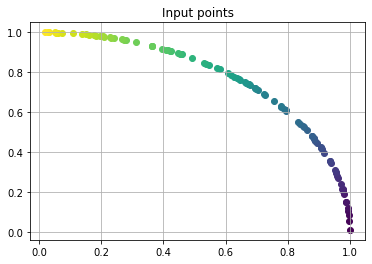

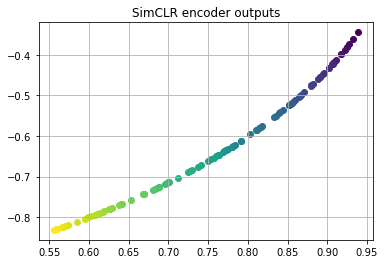

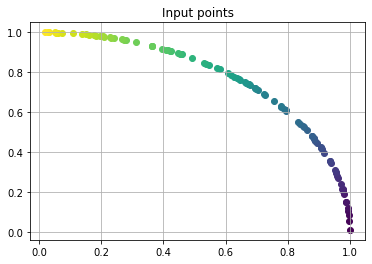

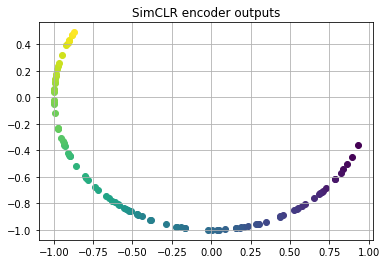

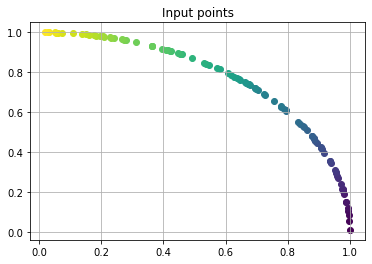

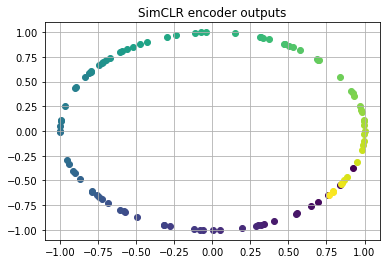

In [22]:
n_epochs = 50
b_size = 1000

train_loader, _ = get_data_loader(
    dataset, val_share=0.0, batch_size=b_size, single_batch=False
)

train_simclr(
    train_loader,
    model,
    n_epochs=n_epochs,
    plot_every=25,
    print_every=250,
    lr=5 * 1e-2,
    decay=1e-5,
)